## Installing offline deps

As this is a code comp, there is no internet. 
So we have to do some silly things to get dependencies in here. 
Why is asciitree such a PITA? 

In [1]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    NormalizeIntensityd,
    RandFlipd,
)

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together. 

In [2]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.

    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension

    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]

    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)

    if n_patches == 1:
        return [0]

    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)

    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.

    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)

    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

## Submission helper functions

These help with getting the submission in the correct format

In [3]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

## Reading in the data

In [4]:
TRAIN_DATA_DIR = "/kaggle/input/numpy-dataset"
TEST_DATA_DIR = "/kaggle/input/czii-cryo-et-object-identification/czii-cryo-et-object-identification"

In [5]:
from typing import List, Optional, Tuple, Union

import torch
import torch.nn as nn
from monai.losses import TverskyLoss, DiceFocalLoss
from monai.networks.nets import UNet

class Unet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Union[Tuple[int, ...], List[int]],
        strides: Union[Tuple[int, ...], List[int]],
        num_res_units: int,
    ):
        super().__init__()
        self.model = UNet(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=channels,
            strides=strides,
            num_res_units=num_res_units,
        )
        # self.loss_fn = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.loss_fn = 'dummy'

    def forward(
        self,
        x: torch.Tensor,
        y: Optional[torch.Tensor],
    ) -> dict[str, torch.Tensor]:

        logits = self.model(x)

        output = {"logits": logits}
        if y is not None:
            loss = self.loss_fn(logits, y)
            output["loss"] = loss

        return output

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [7]:
spatial_dims = 3
in_channels = 1
out_channels = 7
channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)       
num_res_units = 1

In [8]:
import json
# copick_config_path = TRAIN_DATA_DIR + "/copick.config"
copick_config_path = "/kaggle/input/czii-cryo-et-object-identification/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '/kaggle/input/czii-cryo-et-object-identification/train/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [9]:
import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [10]:
# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [11]:
import cc3d

id_to_name = {
    1: "apo-ferritin", 
    2: "beta-amylase",
    3: "beta-galactosidase", 
    4: "ribosome", 
    5: "thyroglobulin", 
    6: "virus-like-particle"
}

particle_radius = {
    'apo-ferritin': 60,
    'beta-amylase': 65,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [12]:
import os
import sys
sys.path.append('/kaggle/project/A/src')

from utils.score import score

In [13]:
def tta_spatial(tomo, patch_size, probability, count):
    
    tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], patch_size)

    tomo_patched_data = [{"image": img} for img in tomo_patches]

    tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

    for i in range(len(tomo_ds)):
        input_tensor = tomo_ds[i]['image'].unsqueeze(0).to(device)
        
        # モデルごとに並列推論
        all_probs = []
        for model in ensemble_models:
            logits = model(input_tensor, None)["logits"]
            probs = torch.softmax(logits, dim=1)  # バッチ内の確率
            all_probs.append(probs)

        avg_probs = torch.mean(torch.stack(all_probs), dim=0)  # モデル間の平均を計算

        # print(avg_probs.shape)

        (z, y, x) = coordinates[i]
        probability[
            :,
            z:z + patch_size,
            y:y + patch_size,
            x:x + patch_size,
        ] += avg_probs[0]

        count[
            :,
            z:z + patch_size,
            y:y + patch_size,
            x:x + patch_size,
        ] += 1

    return probability, count

def tta_axis(tomo, patch_size, probability, count, axis):
    
    tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], patch_size)

    tomo_patched_data = [{"image": img} for img in tomo_patches]

    tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

    for i in range(len(tomo_ds)):
        input_tensor = tomo_ds[i]['image'].unsqueeze(0).to(device)
        # print(input_tensor.shape)
        if axis != -1:
            input_tensor = input_tensor.flip(axis+2)  # z軸方向に反転
        
        # モデルごとに並列推論
        all_probs = []
        for model in ensemble_models:
            logits = model(input_tensor, None)["logits"]
            probs = torch.softmax(logits, dim=1)  # バッチ内の確率
            all_probs.append(probs)

        avg_probs = torch.mean(torch.stack(all_probs), dim=0)  # モデル間の平均を計算

        if axis != -1:
            avg_probs = avg_probs.flip(axis+2)

        (z, y, x) = coordinates[i]
        
        probability[
            :,
            z:z + patch_size,
            y:y + patch_size,
            x:x + patch_size,
        ] += avg_probs[0]

        count[
            :,
            z:z + patch_size,
            y:y + patch_size,
            x:x + patch_size,
        ] += 1

    return probability, count

In [114]:
from torch.nn import ModuleList
import scipy.ndimage as ndi
from sklearn.decomposition import PCA



PROJECT_ID = 'H'
MODE = 'fine-tuning'
NUM_FOLDS = 7
EXP_NO = '002'
MODEL_DIR = f'/kaggle/project/{PROJECT_ID}/{MODE}/output/train/{EXP_NO}'

PATCH_SIZE = int(96 * 1)

# BLOB_THRESHOLD = 500 // 4

SCALEs = [0.000025] * 5
# SCALEs = [0.0000025] * 5
# SCALEs = [0.0000025] * 5
# print(SCALEs)
# SCALEs = [0.005, 0.005, 0.005, 0.005, 0.005] 
# CERTAINTY_THRESHOLDs = [0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
# CERTAINTY_THRESHOLDs = [x * 1 for x in CERTAINTY_THRESHOLDs]
CERTAINTY_THRESHOLDs = [0.0] + [0.75] * 6
# CERTAINTY_THRESHOLD_MULTICLASS = [0.0, 0.5, 0.5, 0.05, 0.7, 0.7, 0.4]

# BLOB_THRESHOLD = [100, 500, 700, 1100, 800, 800]

message = '4 * particle_radius[id_to_name[c]]**3 * np.pi * SCALE / 3'


VALID_DICT = {
    'TS_5_4': 0,
    'TS_6_4': 1,
    'TS_69_2': 2,
    'TS_6_6': 3,
    'TS_73_6': 4,
    'TS_86_3': 5,
    'TS_99_9': 6,
}
# VALID_IDs = ['TS_5_4', 'TS_6_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
VALID_IDs = ['TS_6_4', 'TS_69_2', 'TS_6_6', 'TS_73_6']
# VALID_IDs = ['TS_6_4', 'TS_69_2', 'TS_6_6']
# VALID_IDs = ['TS_5_4', 'TS_6_4', 'TS_69_2']
# VALID_IDs = ['TS_69_2']
# VALID_IDs = ['TS_6_4']

location_df_list = []

for VALID_ID in VALID_IDs:
    VALID_FOLD = VALID_DICT[VALID_ID]
    models = []

    cp = f"{MODEL_DIR}/{EXP_NO}-{VALID_FOLD}/single/best_model.pth"
    print(f'loading {cp}...')
    model = Unet(
        spatial_dims, 
        in_channels, 
        out_channels, 
        channels, 
        strides_pattern, 
        num_res_units
    )
    state_dict = torch.load(cp)
    state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}

    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    models.append(model)

    ensemble_models = ModuleList(models)

    classes = [6]
    with torch.no_grad():
        location_df = []
        for run in root.runs:
            # print(run)
            if run.name != VALID_ID:
                continue

            tomo = run.get_voxel_spacing(10)
            tomo = tomo.get_tomogram(tomo_type).numpy()
            
            probability = torch.zeros((7, 184, 630, 630), dtype=torch.float32, device=device)
            count = torch.zeros((7, 184, 630, 630), dtype=torch.float32, device=device)

            probability, count = tta_axis(tomo=tomo, patch_size=96, probability=probability, count=count, axis=-1)
            probability, count = tta_axis(tomo=tomo, patch_size=120, probability=probability, count=count, axis=0)
            probability, count = tta_axis(tomo=tomo, patch_size=120, probability=probability, count=count, axis=1)
            probability, count = tta_axis(tomo=tomo, patch_size=120, probability=probability, count=count, axis=2)

            probability, count = tta_spatial(tomo, 120, probability, count)

            probability = probability / (count + 0.0001)
            # print(probability.shape)
            # 背景クラスを含む全クラスの閾値をリストで設定 (例)
            thresholds = torch.tensor(CERTAINTY_THRESHOLDs).to(device)  # クラスごとの閾値
            # thresholds = torch.tensor(CERTAINTY_THRESHOLD_MULTICLASS).to(device)  # クラスごとの閾値
            # 最大スコアを持つクラスを取得
            max_scores, arg_classes = torch.max(probability, dim=0)
            # 各クラスごとの閾値をテンソル形状に合わせて拡張
            thresholds_expanded = thresholds.view(-1, 1, 1, 1).expand_as(probability)
            # 最大スコアのクラスに対する閾値
            thresholds_for_max = thresholds_expanded.gather(0, arg_classes.unsqueeze(0)).squeeze(0)
            # スコアが閾値以上の場合、背景クラスより優先
            max_classes = torch.where(
                (max_scores > thresholds_for_max) & (arg_classes != 0),  # 最大スコアが閾値を超え、背景でない
                arg_classes,  # 最大スコアのクラス
                0  # 背景クラス（スコアが閾値未満の場合）
            )
            
            location = {}

            for i, c in enumerate(classes):
                binary_mask = (max_classes == c).cpu().numpy() \
                    if isinstance(max_classes, torch.Tensor) else (max_classes == c)
                # cc = cc3d.connected_components(binary_mask)
                # dilated_mask = ndi.binary_dilation(binary_mask, structure=ndi.generate_binary_structure(3, 2))
                cc = cc3d.connected_components(binary_mask, connectivity=26)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:] * 10.012444
                
                zyx_large = zyx[stats['voxel_counts'][1:] > \
                                4 * particle_radius[id_to_name[c]]**3 * np.pi * SCALEs[i] / 3]
                # zyx_large = zyx[stats['voxel_counts'][1:] > particle_radius[id_to_name[c]]**2 * np.pi * SCALEs[i]]
                # zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD[i]]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])

                location[id_to_name[c]] = xyz

            df = dict_to_df(location, run.name)
            location_df.append(df)
        
        location_df = pd.concat(location_df)
        location_df.insert(loc=0, column='id', value=np.arange(len(location_df)))
        location_df.to_csv(f"{MODEL_DIR}/{EXP_NO}-{VALID_FOLD}/single/location.csv", index=False)
        location_df_list.append(location_df)

        submit_df = location_df
        solution_df = pd.read_csv(f'/kaggle/input/solution/solution_{VALID_ID}.csv')
        val_lb = score(solution_df, location_df, 'row_id', 0.5, 4)
        print(val_lb)
        validation_score_path = f"{MODEL_DIR}/{EXP_NO}-{VALID_FOLD}/single/validation_score_{VALID_ID}_{PATCH_SIZE}.txt"
        if os.path.exists(validation_score_path):
            with open(validation_score_path, "a") as f:
                f.write(f"\n{message}. Appending new score.\n")
                f.write(str(val_lb))
        else:
            with open(validation_score_path, "w") as f:
                f.write(str(val_lb))

loading /kaggle/project/H/fine-tuning/output/train/002/002-1/single/best_model.pth...


<ipython-input-114-9f884512670a>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)
<ipython-input-114-9f884512670a>:83: DeprecationWarning: get_t

0.11295681063122923
loading /kaggle/project/H/fine-tuning/output/train/002/002-2/single/best_model.pth...


Loading dataset: 100%|██████████| 72/72 [00:00<00:00, 361.16it/s]


0.1392174704276615
loading /kaggle/project/H/fine-tuning/output/train/002/002-3/single/best_model.pth...


<ipython-input-114-9f884512670a>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)
<ipython-input-114-9f884512670a>:83: DeprecationWarning: get_t

0.13982683982683983
loading /kaggle/project/H/fine-tuning/output/train/002/002-4/single/best_model.pth...


<ipython-input-114-9f884512670a>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cp)
<ipython-input-114-9f884512670a>:83: DeprecationWarning: get_t

0.14209726443768997


In [110]:
final_location_df = pd.concat(location_df_list, axis=0)
final_location_df.to_csv(f"{MODEL_DIR}/final_location.csv", index=False)
# all_solution_df = pd.read_csv('/home/naoya/kaggle/czii/input/solution/solution.csv')
all_solution_df = pd.read_csv('/kaggle/input/solution/solution_1-4.csv')

final_lb = score(all_solution_df, final_location_df, 'row_id', 0.5, 4)
print(final_lb)
with open(f"{MODEL_DIR}/final_score.txt", "w") as f:
    f.write(str(final_lb))

0.13804018717313513


### Iterate over test set


Below we will: 
1. Read in a run
2. Split it into patches of size (96, 96, 96)
3. Create a dataset from the patches
4. Predict the segmentation mask
5. Glue the mask back together
6. Find the connected components for each class
7. Find the centroids of the connected components
8. Add to the dataframe

Then do this for all runs. 

This can probably be optimized quite a bit. 

In [111]:
import sys
sys.path.append("/kaggle/input/hengck-czii-cryo-et-01")

In [112]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

,particle_type,P,T,hit,miss,fp,precision,recall,f-beta4,weight
0,apo-ferritin,0,229,0,229,0,0.00000,0.000000,0.000000,1
1,beta-amylase,0,47,0,47,0,0.00000,0.000000,0.000000,0
2,beta-galactosidase,0,53,0,53,0,0.00000,0.000000,0.000000,2
3,ribosome,0,180,0,180,0,0.00000,0.000000,0.000000,1
4,thyroglobulin,0,127,0,127,0,0.00000,0.000000,0.000000,2
5,virus-like-particle,78,60,59,1,19,0.75641,0.983333,0.966281,1


lb_score: 0.13804018717313513



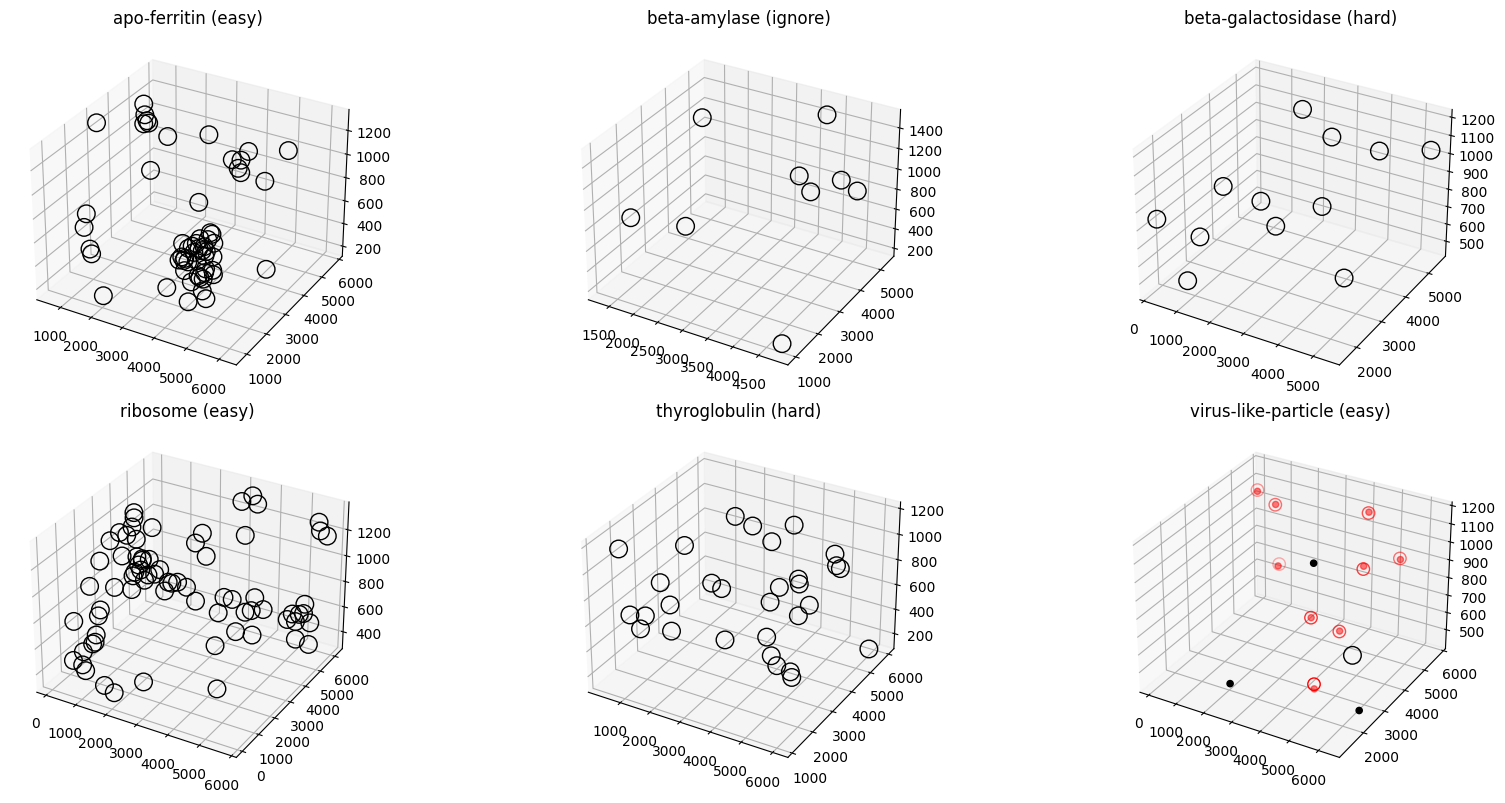

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [113]:
valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):

    eval_df = []
    for id in VALID_IDs:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()

    display(gb)
    return gb, lb_score

submit_df=pd.read_csv(
    f'{MODEL_DIR}/final_location.csv'
)
gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
print('lb_score:',lb_score)
print('')
gb.to_csv(f'{MODEL_DIR}/final_lb.csv', index=False)


#show one ----------------------------------
fig = plt.figure(figsize=(18, 8))

for valid_id in VALID_IDs:
    truth = read_one_truth(valid_id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

    submit_df_ = submit_df[submit_df['experiment']==valid_id]
    for p in PARTICLE:
        p = dotdict(p)
        xyz_truth = truth[p.name]
        xyz_predict = submit_df_[submit_df_['particle_type']==p.name][['x','y','z']].values
        hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
        # print(valid_id, p.name)
        # print('\t num truth   :',len(xyz_truth) )
        # print('\t num predict :',len(xyz_predict) )
        # print('\t num hit  :',len(hit[0]) )
        # print('\t num fp   :',len(fp) )
        # print('\t num miss :',len(miss) )

        ax = fig.add_subplot(2, 3, p.label, projection='3d')
        if hit[0]:
            pt = xyz_predict[hit[0]]
            ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
            pt = xyz_truth[hit[1]]
            ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
        if fp:
            pt = xyz_predict[fp]
            ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
        if miss:
            pt = xyz_truth[miss]
            ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

        ax.set_title(f'{p.name} ({p.difficulty})')

    plt.tight_layout()
    plt.show()